In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import sys
from haversine import haversine

In [3]:
#define current city
city = 'chicago'

In [5]:
#read in all labels geolocation data
geo = gpd.read_file('../../../data/{}/source/all.json'.format(city))

In [7]:
print(geo.total_bounds)

[-88.15451813  41.55007553 -87.58644104  42.09182739]


In [8]:
#read in cv metadata
meta= pd.read_json('../../../data/{}/source/cvMetadata.json'.format(city))

In [9]:
meta

label_id         gsv_panorama_id  label_type_id  agree_count  \
0             8  pMph48Z6Xz2hexFJ7q3d_Q              1            1   
1             9  pMph48Z6Xz2hexFJ7q3d_Q              1            3   
2            10  pMph48Z6Xz2hexFJ7q3d_Q              1            0   
3            11  pMph48Z6Xz2hexFJ7q3d_Q              1            2   
4            12  pMph48Z6Xz2hexFJ7q3d_Q              1            2   
...         ...                     ...            ...          ...   
20036     23391  W-0T8C4yPwf7X4xmi9KuyQ              4            0   
20037     23392  0WudeMR5eIn0N7JTEsEuJA              4            0   
20038     23395  prHSz4j-hPTeSXGhODQXsg              3            0   
20039     23396  1HlBFCqvm_yOGoYzETu9vg              3            0   
20040     23397  zxXM3u-s0w7_Lj8Vgrqc9w              4            0   

       disagree_count  notsure_count  image_width  image_height  sv_image_x  \
0                   1              0        16384          8192        4936   
1                   0              0        16384          8192        9082   
2                   1              0        16384          8192       10739   
3                   0              0        16384          8192        2037   
4                   0              0        16384          8192        1519   
...               ...            ...          ...           ...         ...   
20036               0              0        16384          8192        3398   
20037               0              0        16384          8192        5585   
20038               0              0        16384          8192        9773   
20039               0              0        16384          8192       12820   
20040               0              0        16384          8192        4731   

       sv_image_y  canvas_width  canvas_height  canvas_x  canvas_y  zoom  \
0            -500           720            480       323       184     2   
1            -417           720            480       312       206     2   
2            -461           720            480       408       227     3   
3            -580           720            480       498       234     3   
4            -540           720            480       325       205     3   
...           ...           ...            ...       ...       ...   ...   
20036        -568           720            480       321       224     3   
20037        -686           720            480       179       258     3   
20038        -447           720            480       330       345     3   
20039        -553           720            480       425       394     2   
20040        -748           720            480       419       272     3   

          heading      pitch  photographer_heading  photographer_pitch  
0      136.687500 -18.625000            268.225098           -0.562027  
1      249.937500 -14.125000            268.225098           -0.562027  
2      288.656250 -13.187500            268.225098           -0.562027  
3       49.245537 -16.220982            268.225098           -0.562027  
4       42.636162 -16.033482            268.225098           -0.562027  
...           ...        ...                   ...                 ...  
20036   93.133926 -16.015625             36.771187            0.717570  
20037  158.524551 -18.359375             38.294903            0.593420  
20038  265.241058  -8.937500             36.975445            0.880585  
20039  341.562500  -3.125000             37.269768            0.379456  
20040  125.464287 -19.321428             37.097347            0.774680  

[20041 rows x 19 columns]

In [10]:
meta = meta.drop(columns=['image_width','image_height','sv_image_x','sv_image_y','canvas_width','canvas_height','canvas_x','canvas_y','label_type_id','agree_count','disagree_count','notsure_count'])

In [11]:
#merge metadata and geo data on label_id
df = pd.merge(geo, meta, on='label_id')

In [12]:
#read in label-and-user-ids.csv
user_ids = pd.read_csv('../../../data/shared/label-and-user-ids.csv')
# select only city == current city
user_ids = user_ids[user_ids['city'] == city]

In [13]:
#merge user_ids and df on label_id
df = pd.merge(df, user_ids, on='label_id', how='inner')

In [14]:
#drop city column
df = df.drop(columns=['city'])

In [15]:
# break geometry into lat and lng
df['lat'] = df['geometry'].apply(lambda x: x.y)
df['lng'] = df['geometry'].apply(lambda x: x.x)

In [17]:
#df.explore()

<AxesSubplot: >

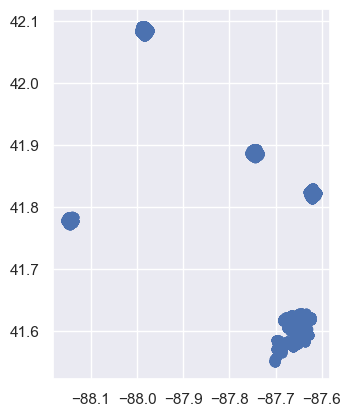

In [16]:
df.plot()

In [17]:
chicago_1 = df.cx[-87.9:-88.1, 42.0:42.1]
chicago_2 = df.cx[-87.7:-87.8, 41.8:42.0]
chicago_3 = df.cx[-87.5:-87.7, 41.8:41.9]
chicago_4 = df.cx[-88.1:-88.2, 41.7:41.8]
chicago_5 = df.cx[-87.6:-87.8, 41.5:41.7]

In [18]:
chicago_5.explore()

In [19]:
print(chicago_1.total_bounds)
print(chicago_2.total_bounds)
print(chicago_3.total_bounds)
print(chicago_4.total_bounds)
print(chicago_5.total_bounds)

[-87.993927    42.07549286 -87.97310638  42.09182739]
[-87.75547028  41.87944412 -87.73557281  41.89422607]
[-87.62966919  41.81287003 -87.60968781  41.83119202]
[-88.15451813  41.77160263 -88.13647461  41.78530502]
[-87.70420074  41.55007553 -87.62294769  41.62950897]


In [20]:
# save to csv
df.to_csv('../../../data/{}/processed-labels/labels_raw_{}.csv'.format(city,city), index = False)

In [21]:
#save df to shapefile
df.to_file('../../../data/{}/processed-labels/labels_raw_{}/labels_raw_{}.shp'.format(city,city,city))